# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s).

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



## Network implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content
!unzip -q /content/drive/MyDrive/seg_data -d /content/data

/content


In [13]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from typing import Type

In [25]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.dropout1 = nn.Dropout(0.05)
        self.dropout2 = nn.Dropout(0.05)
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dropout2(out)
        return  out


class ResNet18FCN(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 13, block: Type[BasicBlock] = BasicBlock) -> None:
        super(ResNet18FCN, self).__init__()
        # Extend your implementation of ResNet18 and turn it into a segmentation network.
        # Add a segmentation head as described in https://arxiv.org/pdf/1411.4038.pdf
        # The simplest possible extension is to simply generate predictions at the
        # last convolutional feature map and upsample the result.

        # the dataset has 13 possible classes
        #num_classes = 13

        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block layers
        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        # Last layers = avg. pooling -> flatten -> fc
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.conv_last = nn.Conv2d(512, out_channels, kernel_size=1, stride=1) #nn.Linear(512, num_classes)
        self.fcn = nn.ConvTranspose2d(512, out_channels, kernel_size=64, stride=32, padding=16)

    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1: # for res block layers 2-4
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        #x = torch.flatten(x, 1)
        #x = self.conv_last(x)
        x = self.fcn(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=13):
        super(UNet, self).__init__()
        # define the neural network blocks for UNet
        # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf

        #encoder
        self.e11 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        #encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

##Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






In [ ]:
!pip install --upgrade --no-cache-dir gdown
#!gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
# if this link does not work try the other link
#!gdown --id 1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv
#!rm -r data
#!mkdir data
#!unzip -q seg_data.zip -d ./data/

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


## Data loader

In [ ]:
from torch.utils.data import Dataset
import glob
import cv2
import numpy as np

class SegmentationDataset(Dataset):

    def __init__(self, train=True):
        dataset_path = "./data/seg_data/" + ("train" if train else "test")
        self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
        self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
        self.resize_shape = (320, 416)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.transform_image(self.images[idx], self.masks[idx])
        sample = {'image': image, "mask": mask, 'idx': idx}

        return sample

In [32]:
import torch
from tqdm.notebook import tqdm

trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [90]:
import torch.optim as optim

#net = UNet(in_channels=3, out_channels=13)
net = ResNet18FCN(in_channels=3, out_channels=13)
net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(net.parameters(), lr=0.0001)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs=10
for epoch in range(epochs):  # loop over the dataset multiple times
    with tqdm(total=len(trainset), desc =str(epoch)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs = data["image"]
          labels = data["mask"]
          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels[:,0,:,:].long())
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
          prog_bar.update(4)

0/10:   0%|          | 0/4000 [00:00<?, ?img/s]

1/10:   0%|          | 0/4000 [00:00<?, ?img/s]

2/10:   0%|          | 0/4000 [00:00<?, ?img/s]

3/10:   0%|          | 0/4000 [00:00<?, ?img/s]

4/10:   0%|          | 0/4000 [00:00<?, ?img/s]

5/10:   0%|          | 0/4000 [00:00<?, ?img/s]

6/10:   0%|          | 0/4000 [00:00<?, ?img/s]

7/10:   0%|          | 0/4000 [00:00<?, ?img/s]

8/10:   0%|          | 0/4000 [00:00<?, ?img/s]

9/10:   0%|          | 0/4000 [00:00<?, ?img/s]

## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation



In [91]:
net.eval()
image_size = 320 * 416

total_intersection = 0
total_samples = 0
iou_sum = 0

with tqdm(total=len(trainset), desc ="test", miniters=int(50), unit='img') as prog_bar:
    for i, data in enumerate(trainloader, 0):
        x = data['image'].cuda()
        pred = net(x).argmax(dim=1)
        y = data['mask'].cuda().squeeze(1)
        batch_intersection = (y == pred)
        #iou = torch.sum(batch_intersection, dim=(1, 2)).float() / image_size
        total_intersection += batch_intersection.sum().item()
        total_samples += x.shape[0]
        #iou_sum += torch.sum(iou)

        prog_bar.update(4)

    total_iou = total_intersection / (total_samples * image_size)
   #mean_iou = iou_sum / total_samples
    print("IoU over the whole test set:", total_iou)
    #print("Mean IoU:", mean_iou.item())


test:   0%|          | 0/4000 [00:00<?, ?img/s]

IoU over the whole test set: 0.9210362022986779


## Visualize the results

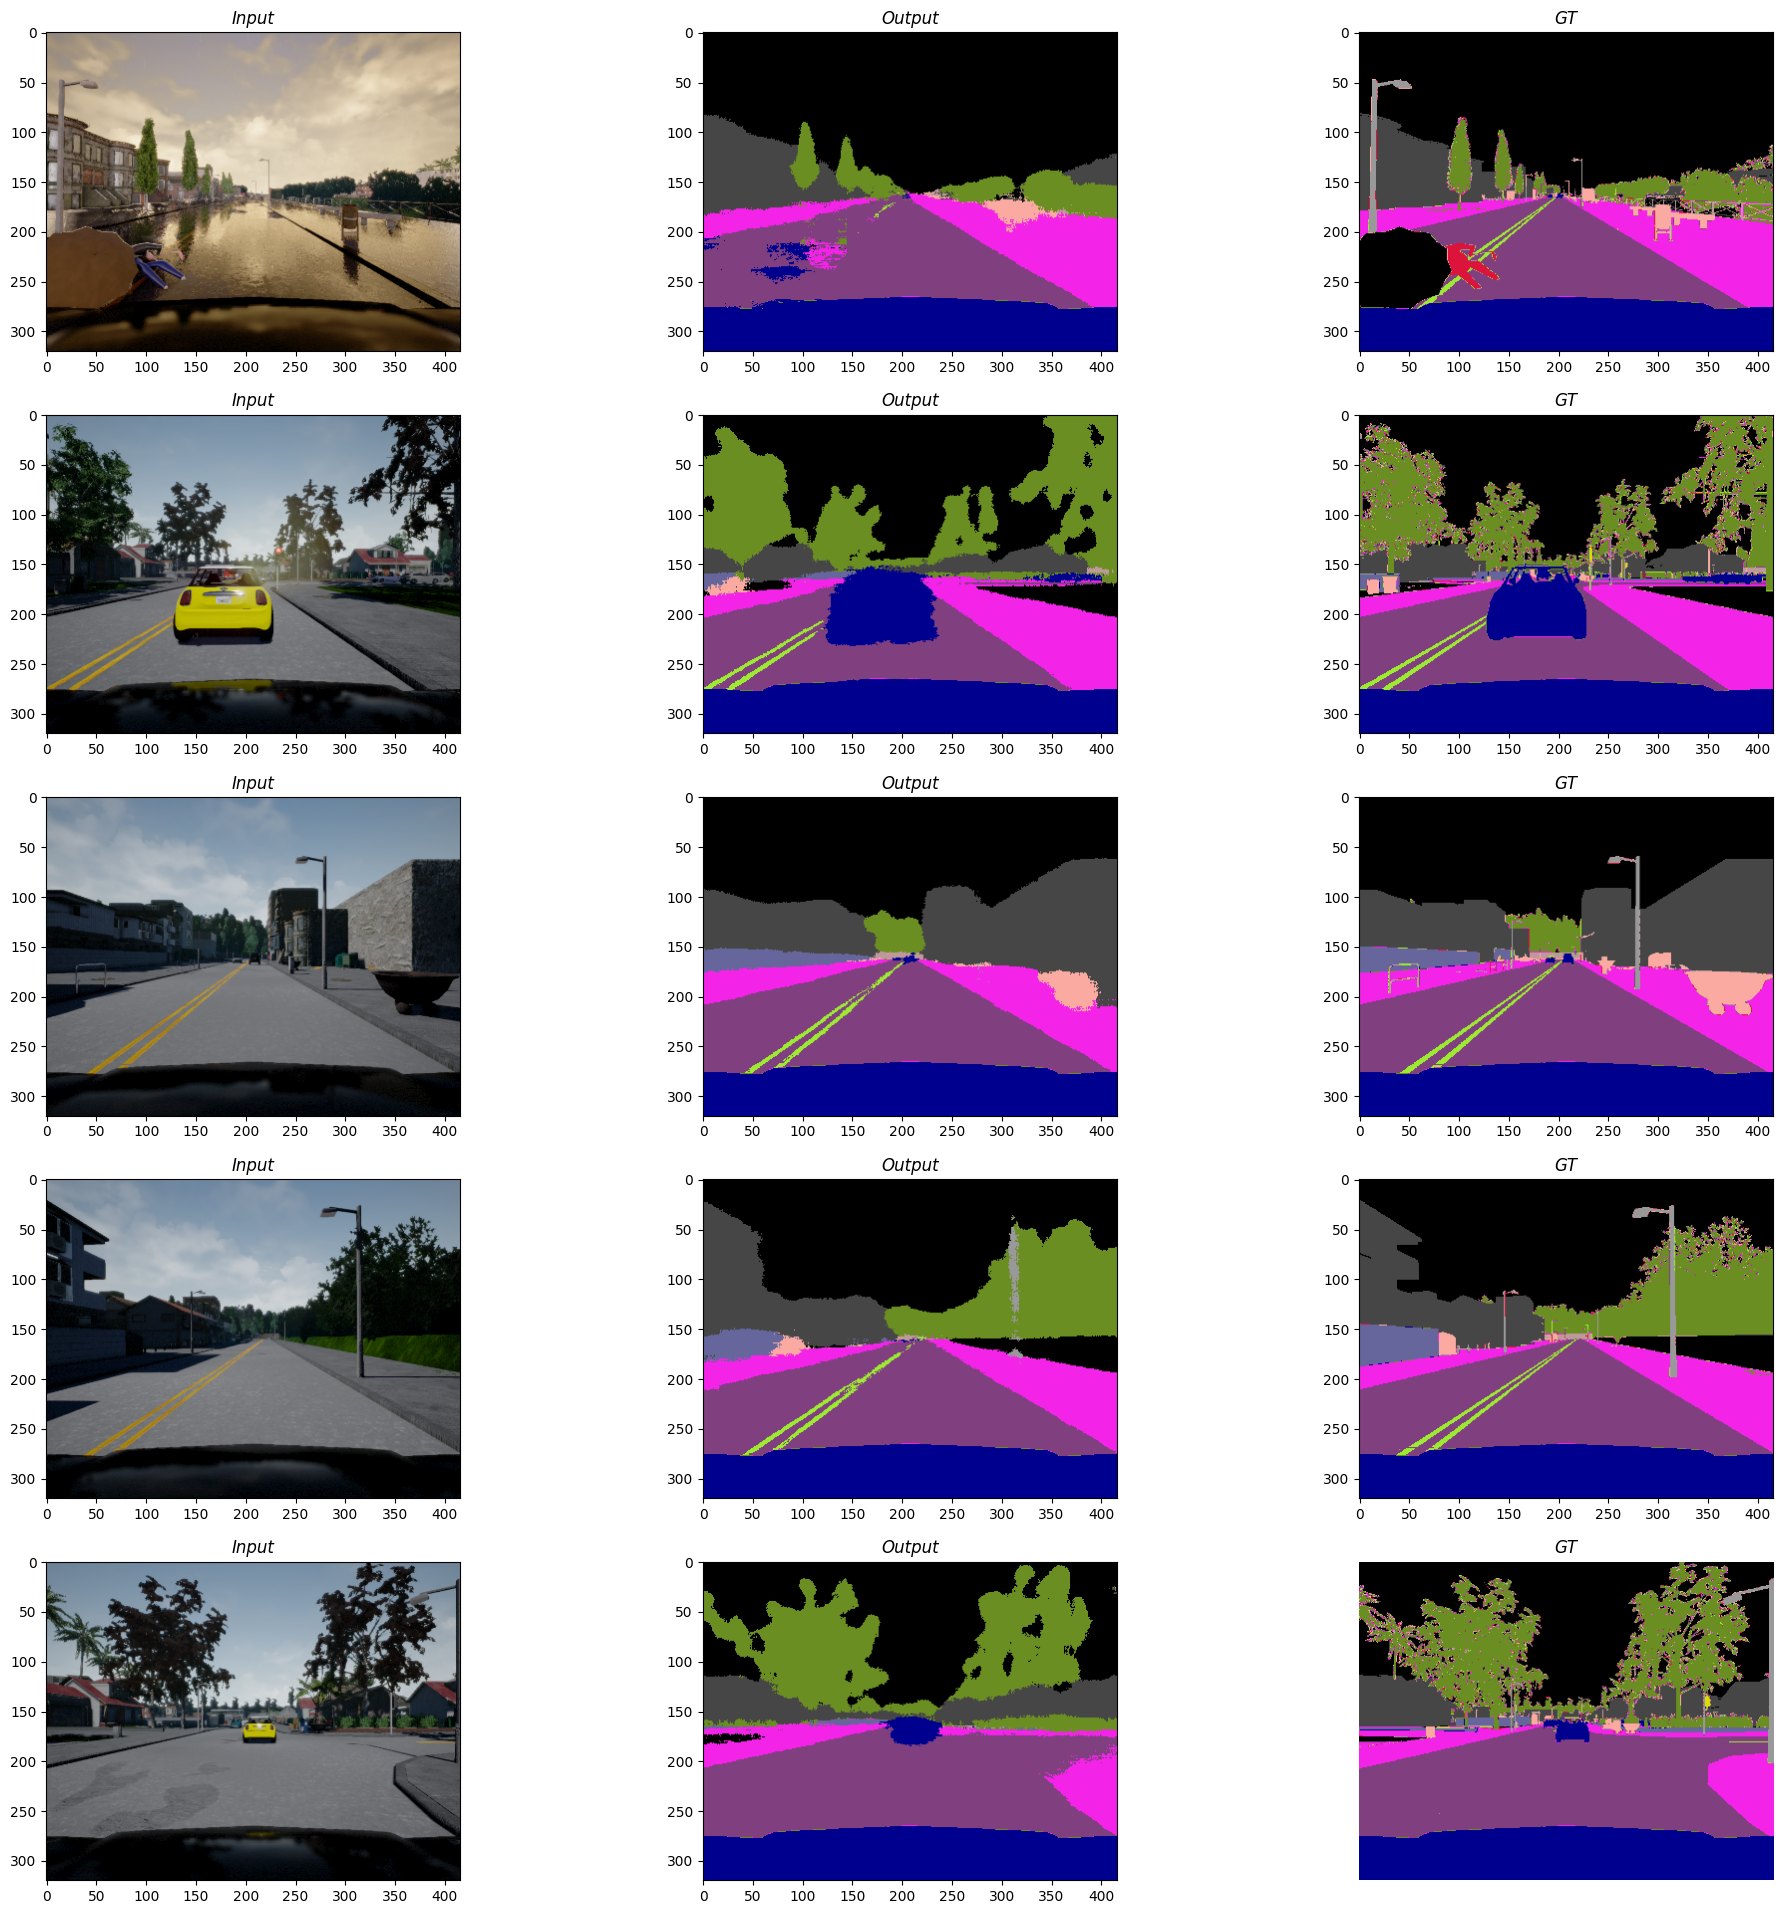

In [92]:
import matplotlib.pyplot as plt

label_colors = np.array([
[0,0,0], # unlabeled
[70,70,70], # building
[190,153,153], # fence
[250,170,160], # other
[220,20,60], # pedestrian
[153,153,153], # pole
[157,234,50], # road line
[128,64,128], # road
[244,35,232], # sidewalk
[107,142,35], # vegetation
[0,0,142], # car
[102,102,156], # wall
[220,220,0], # traffic sign
])


net.eval()


fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[np.random.randint(len(testset))]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy()
  seg_mask = np.argmax(out_image,axis=0)
  seg_mask_color = label_colors[seg_mask]
  gt_mask_color = label_colors[labels[0,:,:]]

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  labels = labels[0,:,:]
  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(img)
  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("Output", fontstyle='italic')
  plt.imshow(seg_mask_color)
  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(gt_mask_color)

plt.axis('off')
plt.show()